# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

GPU Ocean-modules:

In [2]:
from gpuocean.ensembles import MultiResOceanStateEnsemble
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [6]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

## Simulation

In [7]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


### Refined Simulation

Defining local area

In [8]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

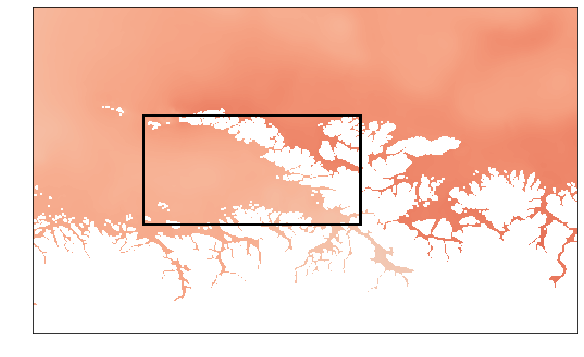

In [9]:
eta, hu, hv = sim.download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

import matplotlib.patches as patches
area = patches.Rectangle((loc[0][0], loc[0][1]), loc[1][1]-loc[0][1], loc[1][0]-loc[0][0], edgecolor='black', facecolor='none', lw=3)
ax.add_patch(area)

Extract local IC

In [10]:
data_args_loc = {}

In [11]:
data_args_loc["eta0"], data_args_loc["hu0"], data_args_loc["hv0"] = [x[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]] for x in sim.download()]

In [12]:
data_args_loc["NY"], data_args_loc["NX"] = np.array(data_args_loc["eta0"].shape)
data_args_loc["ny"], data_args_loc["nx"] = np.array(data_args_loc["eta0"].shape)-4

In [13]:
data_args_loc["dx"], data_args_loc["dy"] = sim.dx, sim.dy 

In [14]:
data_args_loc["H"] = sim.downloadBathymetry()[0][loc[0][0]:loc[1][0]+1,loc[0][1]:loc[1][1]+1]

In [15]:
data_args_loc["g"] = sim.g
data_args_loc["r"] = sim.r
data_args_loc["f"] = sim.f

In [16]:
data_args_loc["angle"] = NetCDFInitialization.get_texture(sim, "angle_tex")[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]]

In [17]:
data_args_loc["f"] = NetCDFInitialization.get_texture(sim, "coriolis_f_tex")[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]]

In [18]:
wind_y0 = np.floor(loc[0][0]/(sim.ny+4)*sim.wind_stress.wind_u.shape[1]).astype(int)
wind_x0 = np.floor(loc[0][1]/(sim.nx+4)*sim.wind_stress.wind_u.shape[2]).astype(int)

wind_y1 = np.ceil(loc[1][0]/(sim.ny+4)*sim.wind_stress.wind_u.shape[1]).astype(int)
wind_x1 = np.ceil(loc[1][1]/(sim.nx+4)*sim.wind_stress.wind_u.shape[2]).astype(int)

In [19]:
from gpuocean.utils import WindStress

data_args_loc["wind"] = WindStress.WindStress(t=sim.wind_stress.t, wind_u=sim.wind_stress.wind_u[:,wind_y0:wind_y1,wind_x0:wind_x1], wind_v=sim.wind_stress.wind_v[:,wind_y0:wind_y1,wind_x0:wind_x1])

In [20]:
data_args_loc["boundary_conditions"] = copy.deepcopy(sim.boundary_conditions)

Refined local IC

In [21]:
data_args_refined = NetCDFInitialization.removeMetadata(NetCDFInitialization.rescaleInitialConditions(data_args_loc, scale=1.2))

NOTE: Later on, no relaxation (spongeCells=0) will be needed due to a flux correction term!

In [22]:
data_args_refined["boundary_conditions"] = copy.deepcopy(sim.boundary_conditions)

Init new refined sim

In [23]:
sim_refined = CDKLM16.CDKLM16(gpu_ctx_refined, **sim_args, **data_args_refined)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


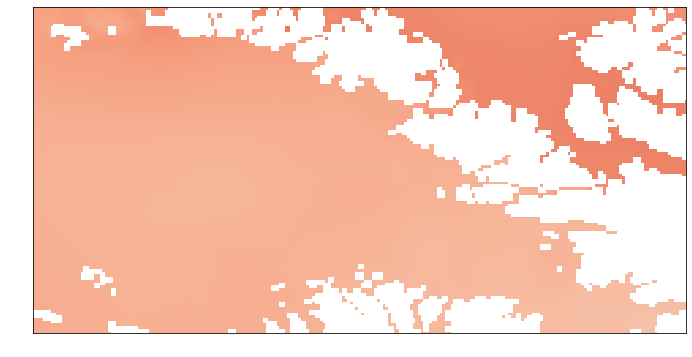

In [24]:
eta, hu, hv = sim_refined.download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

### Time-Stepping

First model time step

In [25]:
eta, hu, hv = sim.download()
t0 = sim.t
bc_data_north_t0 = [x[loc[1][0]+1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
bc_data_south_t0 = [x[loc[0][0]-1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
bc_data_west_t0 = [x[loc[0][0]:loc[1][0], loc[0][1]-1] for x in [eta, hu, hv]]
bc_data_east_t0 = [x[loc[0][0]:loc[1][0], loc[1][1]+1] for x in [eta, hu, hv]]

In [26]:
sim.step(sim.model_time_step)

60.0

In [27]:
eta, hu, hv = sim.download()
t1 = sim.t
bc_data_north_t1 = [x[loc[1][0]+1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
bc_data_south_t1 = [x[loc[0][0]-1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
bc_data_west_t1 = [x[loc[0][0]:loc[1][0], loc[0][1]-1] for x in [eta, hu, hv]]
bc_data_east_t1 = [x[loc[0][0]:loc[1][0], loc[1][1]+1] for x in [eta, hu, hv]]

In [28]:
from gpuocean.utils import Common
t = [t0, t1]
for cardinal in ["north", "south", "east", "west"]:
    exec("{0} = Common.SingleBoundaryConditionData(h = [bc_data_{0}_t0[0], bc_data_{0}_t1[0]],\
                                            hu = [bc_data_{0}_t0[1], bc_data_{0}_t1[1]],\
                                            hv = [bc_data_{0}_t0[2], bc_data_{0}_t1[2]])".format(cardinal))
bc_data = Common.BoundaryConditionsData(t=t, north=north, south=south, east=east, west=west)

In [29]:
sim_refined.bc_kernel = Common.BoundaryConditionsArakawaA(gpu_ctx_refined, sim_refined.nx, sim_refined.ny, 2, 2, \
                                                           sim_refined.boundary_conditions, bc_data)


In [30]:
sim_refined.step(sim.model_time_step)

60.0

Repeated model time steps

In [31]:
while sim.t < 3600:
    eta, hu, hv = sim.download()
    t0 = sim.t
    bc_data_north_t0 = [x[loc[1][0]+1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
    bc_data_south_t0 = [x[loc[0][0]-1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
    bc_data_west_t0 = [x[loc[0][0]:loc[1][0], loc[0][1]-1] for x in [eta, hu, hv]]
    bc_data_east_t0 = [x[loc[0][0]:loc[1][0], loc[1][1]+1] for x in [eta, hu, hv]]

    sim.step(sim.model_time_step)

    eta, hu, hv = sim.download()
    t1 = sim.t
    bc_data_north_t1 = [x[loc[1][0]+1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
    bc_data_south_t1 = [x[loc[0][0]-1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
    bc_data_west_t1 = [x[loc[0][0]:loc[1][0], loc[0][1]-1] for x in [eta, hu, hv]]
    bc_data_east_t1 = [x[loc[0][0]:loc[1][0], loc[1][1]+1] for x in [eta, hu, hv]]

    t = [t0, t1]
    for cardinal in ["north", "south", "east", "west"]:
        exec("{0} = Common.SingleBoundaryConditionData(h = [bc_data_{0}_t0[0], bc_data_{0}_t1[0]],\
                                                hu = [bc_data_{0}_t0[1], bc_data_{0}_t1[1]],\
                                                hv = [bc_data_{0}_t0[2], bc_data_{0}_t1[2]])".format(cardinal))
    bc_data = Common.BoundaryConditionsData(t=t, north=north, south=south, east=east, west=west)

    sim_refined.bc_kernel = Common.BoundaryConditionsArakawaA(gpu_ctx_refined, sim_refined.nx, sim_refined.ny, 2, 2, \
                                                           sim_refined.boundary_conditions, bc_data)

    sim_refined.step(sim.model_time_step)

In [32]:
eta, hu, hv = sim.download()
eta_refined, hu_refined, hv_refined = sim_refined.download()

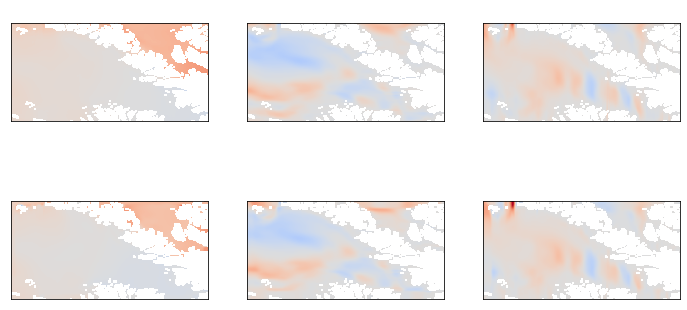

In [33]:
fig, axs = plt.subplots(2,3,figsize=(12,6))

axs[0,0].imshow(eta[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[0,0].set_title("eta (coarse)")
axs[0,1].imshow(hu[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,1].set_title("hu (coarse)")
axs[0,2].imshow(hv[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,2].set_title("hv (coarse)")

axs[1,0].imshow(eta_refined, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[1,0].set_title("eta (refined)")
axs[1,1].imshow(hu_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,1].set_title("hu (refined)")
axs[1,2].imshow(hv_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,2].set_title("hv (refined)")

for ax_s in axs:
    for ax in ax_s:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])